# Naive Bayes

In [18]:
%pip install kagglehub numpy pandas seaborn matplotlib scikit-learn graphviz


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTENC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier

from math import sqrt, pi, exp

## Model from Scratch

In [20]:
# --- NaiveBayesClassifier From Scratch ---
class NaiveBayesClassifier:
    def __init__(self, categorical_features, numerical_features, target_feature, use_add1_smoothing=True):
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.target_feature = target_feature
        self.use_add1_smoothing = use_add1_smoothing

        self.classes = []
        self.prior_probs = {} # P(Class)
        self.likelihoods_categorical = {} # P(Feature_cat | Class) with smoothing
        self.numerical_features_stats = {} # {Class: {Feature_num: {'mean': .., 'std': ..}}}
        self.feature_possible_values = {} # For smoothing denominator

    def fit(self, df):
        """
        ฝึกโมเดล Naive Bayes โดยคำนวณ Prior, Likelihoods, และ Stats สำหรับ Numerical Features
        **Likelihoods สำหรับ Categorical Predictors จะไม่ใช้ Add-1 Smoothing**
        """
        self.classes = df[self.target_feature].unique()
        total_samples = len(df)

        # 1. คำนวณ Prior Probabilities
        for cls in self.classes:
            self.prior_probs[cls] = df[df[self.target_feature] == cls].shape[0] / total_samples

        # 2. คำนวณ Likelihoods สำหรับ Categorical Predictors (ไม่มี Smoothing)
        for feature in self.categorical_features:
            self.feature_possible_values[feature] = df[feature].nunique() # ไม่ได้ใช้แล้วถ้าไม่ smoothing
            for cls in self.classes:
                if cls not in self.likelihoods_categorical:
                    self.likelihoods_categorical[cls] = {}
                self.likelihoods_categorical[cls][feature] = {}

                df_class = df[df[self.target_feature] == cls]
                total_count_class = df_class.shape[0]

                for feat_value in df[feature].unique():
                    count_feat_class = df_class[feature].value_counts().get(feat_value, 0)

                    # *** จุดที่แก้ไข 2: ใช้เงื่อนไข use_add1_smoothing ***
                    if self.use_add1_smoothing:
                        prob = (count_feat_class + 1) / (total_count_class + self.feature_possible_values[feature])
                    else:
                        if total_count_class > 0:
                            prob = count_feat_class / total_count_class
                        else:
                            prob = 0.0 # ถ้าไม่มีข้อมูลในคลาสนี้เลย ให้ Likelihood เป็น 0

                    self.likelihoods_categorical[cls][feature][feat_value] = prob

        # 3. คำนวณ Mean และ Standard Deviation สำหรับ Numerical Predictors
        for feature in self.numerical_features:
            for cls in self.classes:
                if cls not in self.numerical_features_stats:
                    self.numerical_features_stats[cls] = {}

                df_class_feature = df[df[self.target_feature] == cls][feature]
                self.numerical_features_stats[cls][feature] = {
                    'mean': df_class_feature.mean(),
                    'std': df_class_feature.std(ddof=1) # ddof=1 for sample std dev
                }
                # Handle cases where std dev is 0 (e.g., all values are same in a class)
                if self.numerical_features_stats[cls][feature]['std'] == 0:
                    self.numerical_features_stats[cls][feature]['std'] = 1e-9 # Prevent division by zero, small epsilon

    def _normal_pdf(self, x, mean, std):
        """Probability Density Function for Normal Distribution."""
        if std == 0: # Should be handled by epsilon in fit, but as a safeguard
            return 1.0 if x == mean else 0.0
        exponent = exp(-((x - mean) ** 2) / (2 * (std ** 2)))
        return (1 / (sqrt(2 * pi) * std)) * exponent

    def _calculate_unnormalized_posterior_with_terms(self, query_features, target_label):
        """
        คำนวณ Numerator (Score) สำหรับคลาสที่ระบุ พร้อมส่งกลับเทอมการคูณแต่ละตัว
        Score = P(X|c) * P(c)
        """
        score = self.prior_probs[target_label]
        terms = [f"{self.prior_probs[target_label]:.4f}"] # เก็บเฉพาะตัวเลขสำหรับส่วน (0.XX * 0.YY...)

        # สำหรับแสดง P(Yes) = ... หรือ P(No) = ... ในบรรทัดแรกของ P(X|c)*P(c)
        detailed_terms_display = [f"P({target_label}) = {self.prior_probs[target_label]:.4f}"]

        for feat_name, feat_value in query_features.items():
            if feat_name in self.categorical_features:
                p_feat_given_label = self.likelihoods_categorical[target_label][feat_name].get(feat_value, 0)
                score *= p_feat_given_label

                display_value = feat_value
                terms.append(f"{p_feat_given_label:.4f}")
                detailed_terms_display.append(f"P({feat_name}={display_value}|{target_label}) = {p_feat_given_label:.4f}")
            elif feat_name in self.numerical_features:
                mean = self.numerical_features_stats[target_label][feat_name]['mean']
                std = self.numerical_features_stats[target_label][feat_name]['std']
                p_feat_given_label = self._normal_pdf(feat_value, mean, std)
                score *= p_feat_given_label
                terms.append(f"{p_feat_given_label:.4f}")
                detailed_terms_display.append(f"PDF({feat_name}={feat_value}|{target_label}) = {p_feat_given_label:.4f}")
            else:
                # This should ideally not happen if features are correctly defined
                print(f"Warning: Feature '{feat_name}' not recognized during prediction. Skipping.")
        return score, terms, detailed_terms_display

    def predict_proba(self, query_features):
        """
        ทำนาย Posterior Probabilities สำหรับแต่ละคลาส
        คืนค่าเป็น dictionary {class: probability}
        """
        scores = {}
        # We don't need detailed terms for predict_proba, only for display
        for cls in self.classes:
            score, _, _ = self._calculate_unnormalized_posterior_with_terms(query_features, cls)
            scores[cls] = score

        total_score = sum(scores.values())

        posterior_probs = {}
        if total_score > 0:
            for cls in self.classes:
                posterior_probs[cls] = scores[cls] / total_score
        else:
            for cls in self.classes:
                posterior_probs[cls] = 0.0
            print("Warning: All unnormalized scores are zero. Posterior probabilities set to 0.0.")

        return posterior_probs

    def predict(self, query_features):
        """
        ทำนายคลาสที่มีความน่าจะเป็นสูงสุด
        """
        posterior_probs = self.predict_proba(query_features)

        if posterior_probs:
            return max(posterior_probs, key=posterior_probs.get)
        else:
            return None

## Preprocessing

In [21]:
dataset_path = "../Breast_Cancer_Preprocessed.csv"
df = pd.read_csv(dataset_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       4024 non-null   int64  
 1   Tumor Size                4024 non-null   int64  
 2   Estrogen Status           4024 non-null   int64  
 3   Progesterone Status       4024 non-null   int64  
 4   Regional Node Examined    4024 non-null   int64  
 5   Reginol Node Positive     4024 non-null   int64  
 6   Survival Months           4024 non-null   int64  
 7   Status                    4024 non-null   int64  
 8   T Stage Ordinal           4024 non-null   float64
 9   N Stage Ordinal           4024 non-null   float64
 10  M Stage Ordinal           4024 non-null   float64
 11  Differentiate Ordinal     4024 non-null   float64
 12  Marital Status_Divorced   4024 non-null   int64  
 13  Marital Status_Married    4024 non-null   int64  
 14  Marital 

## Training

### Model Optimization Checklist

- features need to be class (convert numerical with binning/distribution)
- zero-frequency problem
- features are conditionally independent given the class

In [22]:
# 1. กำหนด Features และ Target
categorical_feats = [
    "Progesterone Status",
    "N Stage Ordinal",
    "Differentiate Ordinal",
    "Race_Other",
    "Marital Status_Divorced",
]
numerical_feats = []
target_feat = "Status"

# categorical_feats = [
#     "differentiate",
#     "T Stage Encoded",
#     "M Stage Encoded",
#     "N Stage Encoded",
#     "Estrogen Status Encoded",
#     "Progesterone Status Encoded",
#     "Race_Black",
#     "Race_Other",
#     "Race_White",
#     "Marital_Divorced",
#     "Marital_Married",
#     "Marital_Separated",
#     "Marital_Single ",
#     "Marital_Widowed",
# ]
# numerical_feats = [
#     "Age",
#     "Tumor Size",
#     "Regional Node Examined",
#     "Reginol Node Positive",
#     "Survival Months",
# ]
# target_feat = "Status_encoded"

In [23]:
# X = df.drop(columns=[target_feat])
X = df[
    [
        "Progesterone Status",
        "N Stage Ordinal",
        "Differentiate Ordinal",
        "Race_Other",
        "Marital Status_Divorced",
    ]
]
y = df[target_feat]

In [24]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Combine X_train and y_train back to a DataFrame if your class expects one
train_df = X_train.copy()
train_df[target_feat] = y_train

test_df = X_test.copy()
test_df[target_feat] = y_test

alive_count = (y_test == 0).sum()
dead_count = (y_test == 1).sum()

print(f"number of alive patients: {alive_count}\nnumber of dead patients: {dead_count}")

number of alive patients: 685
number of dead patients: 120


In [25]:
# Oversampling
categorical_features = [
    X_train.columns.get_loc(c)
    for c in X_train.columns
    if "Marital Status" in c or "Race" in c
]


sm = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [26]:
# 2. fit model
nb_model = NaiveBayesClassifier(
    categorical_feats, numerical_feats, target_feat, use_add1_smoothing=False
)

# this take the entire df
nb_model.fit(train_df)

In [27]:
# Step 1 : Calculate Prior Probability of Classes P(C)
print(f"\nP(1) = {nb_model.prior_probs[1]:.4f}")
print(f"P(0) = {nb_model.prior_probs[0]:.4f}")

# alive and dead have equal number => P(0) = P(1) = 0.5000


P(1) = 0.1541
P(0) = 0.8459


In [28]:
# Step 2 : Calculate the Likelihood Table for all features

total_yes_samples = df[df[target_feat] == 1].shape[0]
total_no_samples = df[df[target_feat] == 0].shape[0]

for feature_name in categorical_feats:
    print(f"\n=== Likelihood Table for {feature_name.capitalize()} ===")
    num_unique_feature_values = df[feature_name].nunique()
    for feat_value in sorted(df[feature_name].unique()):
        display_feat_value = feat_value

        count_feat_class_yes = df[
            (df[target_feat] == 1) & (df[feature_name] == feat_value)
        ].shape[0]
        count_feat_class_no = df[
            (df[target_feat] == 0) & (df[feature_name] == feat_value)
        ].shape[0]

        denominator_yes = total_yes_samples + num_unique_feature_values
        denominator_no = total_no_samples + num_unique_feature_values

        if nb_model.use_add1_smoothing:
            fraction_yes_str = f"{count_feat_class_yes + 1}/{total_yes_samples + num_unique_feature_values}"
            fraction_no_str = f"{count_feat_class_no + 1}/{total_no_samples + num_unique_feature_values}"
        else:  # กรณีไม่มี smoothing
            fraction_yes_str = (
                f"{count_feat_class_yes}/{total_yes_samples}"
                if total_yes_samples > 0
                else "0/0"
            )
            fraction_no_str = (
                f"{count_feat_class_no}/{total_no_samples}"
                if total_no_samples > 0
                else "0/0"
            )

        yes_prob = nb_model.likelihoods_categorical[1][feature_name].get(
            feat_value, 0
        )
        no_prob = nb_model.likelihoods_categorical[0][feature_name].get(
            feat_value, 0
        )

        print(
            f"{str(display_feat_value):9s} | P({str(display_feat_value):9s} | Yes) : {fraction_yes_str:<10s} = {yes_prob:.2f} | P({str(display_feat_value):9s} | No) : {fraction_no_str:<10s} = {no_prob:.2f}"
        )


=== Likelihood Table for Progesterone status ===
0         | P(0         | Yes) : 204/616    = 0.33 | P(0         | No) : 494/3408   = 0.15
1         | P(1         | Yes) : 412/616    = 0.67 | P(1         | No) : 2914/3408  = 0.85

=== Likelihood Table for N stage ordinal ===
0.0       | P(0.0       | Yes) : 270/616    = 0.45 | P(0.0       | No) : 2462/3408  = 0.72
1.0       | P(1.0       | Yes) : 165/616    = 0.27 | P(1.0       | No) : 655/3408   = 0.19
2.0       | P(2.0       | Yes) : 181/616    = 0.29 | P(2.0       | No) : 291/3408   = 0.09

=== Likelihood Table for Differentiate ordinal ===
0.0       | P(0.0       | Yes) : 263/616    = 0.43 | P(0.0       | No) : 848/3408   = 0.25
1.0       | P(1.0       | Yes) : 305/616    = 0.49 | P(1.0       | No) : 2046/3408  = 0.60
2.0       | P(2.0       | Yes) : 39/616     = 0.07 | P(2.0       | No) : 504/3408   = 0.15
3.0       | P(3.0       | Yes) : 9/616      = 0.01 | P(3.0       | No) : 10/3408    = 0.00

=== Likelihood Table for Race_ot

In [29]:
# 3. Set query
# Pandas DataFrame X into a list of dictionaries (objects)

querys = X_test.to_dict(orient="records")
querys

[{'Progesterone Status': 1,
  'N Stage Ordinal': 0.0,
  'Differentiate Ordinal': 0.0,
  'Race_Other': 0,
  'Marital Status_Divorced': 0},
 {'Progesterone Status': 1,
  'N Stage Ordinal': 0.0,
  'Differentiate Ordinal': 1.0,
  'Race_Other': 0,
  'Marital Status_Divorced': 0},
 {'Progesterone Status': 0,
  'N Stage Ordinal': 1.0,
  'Differentiate Ordinal': 1.0,
  'Race_Other': 0,
  'Marital Status_Divorced': 0},
 {'Progesterone Status': 1,
  'N Stage Ordinal': 1.0,
  'Differentiate Ordinal': 1.0,
  'Race_Other': 0,
  'Marital Status_Divorced': 0},
 {'Progesterone Status': 1,
  'N Stage Ordinal': 0.0,
  'Differentiate Ordinal': 2.0,
  'Race_Other': 0,
  'Marital Status_Divorced': 0},
 {'Progesterone Status': 1,
  'N Stage Ordinal': 0.0,
  'Differentiate Ordinal': 0.0,
  'Race_Other': 0,
  'Marital Status_Divorced': 0},
 {'Progesterone Status': 1,
  'N Stage Ordinal': 0.0,
  'Differentiate Ordinal': 1.0,
  'Race_Other': 0,
  'Marital Status_Divorced': 0},
 {'Progesterone Status': 1,
  'N S

In [30]:
# 4. Posterior Probabilities (Unnormalized)
probabilities = []

for query in querys:
    score_yes, terms_numerical_yes, terms_display_yes = (
        nb_model._calculate_unnormalized_posterior_with_terms(query, 1)
    )

    # Display with 4 decimal places for consistency
    formatted_numerical_terms_yes = [
        f"{float(term):.4f}" for term in terms_numerical_yes
    ]

    score_no, terms_numerical_no, terms_display_no = (
        nb_model._calculate_unnormalized_posterior_with_terms(query, 0)
    )

    # Display with 4 decimal places for consistency
    formatted_numerical_terms_no = [f"{float(term):.4f}" for term in terms_numerical_no]

    probabilities.append((score_yes, score_no))

In [31]:
# 5. Final Decision (Normalized Posterior Probabilities)
prob_trues = []

for prob in probabilities:
    (score_yes, score_no) = prob
    total_unnormalized_score = score_yes + score_no

    posterior_yes_normalized = (
        (score_yes / total_unnormalized_score) * 100
        if total_unnormalized_score > 0
        else 0
    )
    posterior_no_normalized = (
        (score_no / total_unnormalized_score) * 100
        if total_unnormalized_score > 0
        else 0
    )

    prob_trues.append(posterior_yes_normalized)

    # print("\n--- Final Decision ---")
    # print(f"P(Play=Yes | x) = {score_yes:.4f} ({posterior_yes_normalized:.2f}%)")
    # print(f"P(Play=No  | x) = {score_no:.4f} ({posterior_no_normalized:.2f}%)")

prob_trues = np.array(prob_trues)
y_pred = (prob_trues >= 50).astype(int)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Evaluation

In [32]:
# train test split
score = accuracy_score(y_test, y_pred)
score

0.8596273291925466

In [33]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       685
           1       0.61      0.16      0.25       120

    accuracy                           0.86       805
   macro avg       0.74      0.57      0.59       805
weighted avg       0.83      0.86      0.82       805



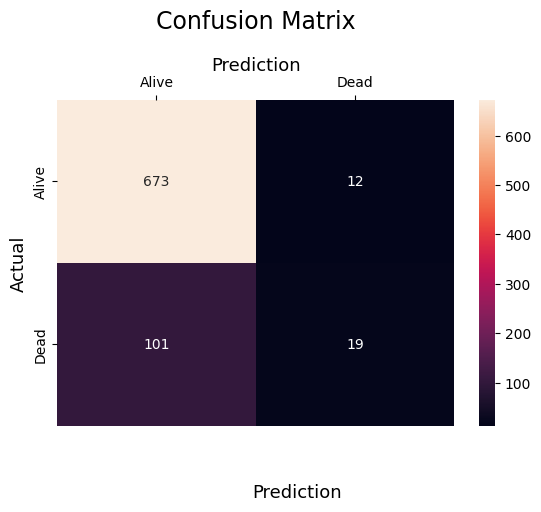

In [34]:
# Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    xticklabels=["Alive", "Dead"],
    yticklabels=["Alive", "Dead"],
)
plt.ylabel("Actual", fontsize=13)
plt.title("Confusion Matrix", fontsize=17, pad=20)
plt.gca().xaxis.set_label_position("top")
plt.xlabel("Prediction", fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, "Prediction", ha="center", fontsize=13)
plt.show()

In [35]:
# # ROC & AUC

# # predict probabilities
# lr_probs = nb_model.predict_proba(test_df)
# # keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# # calculate scores
# ns_auc = roc_auc_score(y_test, lr_probs)
# lr_auc = roc_auc_score(y_test, lr_probs)
# # summarize scores
# print('Logistic: ROC AUC=%.3f' % (lr_auc))

# # calculate roc curves
# lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# # plot the roc curve for the model
# plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # show the legend
# plt.legend()
# # show the plot
# plt.show()